In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from datetime import datetime
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import torchtext
import os
import re
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import pandas as pd
#from utils import train, set_device, compute_accuracy

seed = 265
torch.manual_seed(seed)

## Hjelpefunksjonene fra utils.py

In [14]:

def set_device(device=None):
    """
    Helper function to set device
    """
    if device is None:
        device = (
            torch.device('cuda') if torch.cuda.is_available()
            else torch.device('cpu'))
        print(f"On device {device}.")
    return device


def train(n_epochs, optimizer, model, loss_fn, train_loader, val_loader=None, device=None):
    device = set_device(device)

    n_batch_train = len(train_loader)
    losses_train = []
    losses_val = []
    model.train()
    optimizer.zero_grad(set_to_none=True)

    for epoch in range(1, n_epochs + 1):

        loss_train = 0.0
        for contexts, targets in train_loader:

            contexts = contexts.to(device=device)
            targets = targets.to(device=device)

            outputs = model(contexts)

            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_train += loss.item()

        losses_train.append(loss_train / n_batch_train)

        if val_loader is not None:
            loss_val = 0.0
            n_batch_val = len(val_loader)
            model.eval()
            with torch.no_grad():
                for contexts, targets in val_loader:
                    contexts = contexts.to(device=device)
                    targets = targets.to(device=device)
                    outputs = model(contexts)
                    loss_val += loss_fn(outputs, targets).item()
            losses_val.append(loss_val / n_batch_val)
            model.train()

        print('{}  |  Epoch {}  |  Training loss {:.5f} | Validation loss {:.5f}'.format(
            datetime.now().time(), epoch, losses_train[-1], losses_val[-1] if losses_val else 0.0))

    # plot the loss graphs
    plt.plot(losses_train, label='Training loss')
    if losses_val:
        plt.plot(losses_val, label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return losses_train, losses_val


def compute_accuracy(model, loader, device=None):
    model.eval()
    device = set_device(device)

    correct = 0
    total = 0

    with torch.no_grad():
        for contexts, targets in loader:
            contexts = contexts.to(device=device)
            targets = targets.to(device=device)

            outputs = model(contexts)
            _, predicted = torch.max(outputs, dim=1)
            total += len(targets)
            correct += int((predicted == targets).sum())

    acc =  correct / total
    return acc


# 2.1 Word embedding

## Task 2.1.1 and 2.1.2

In [15]:
# tokenizer will split a long text into a list of english words
TOKENIZER_EN = get_tokenizer('basic_english')
# Where we will store / load all our models, datasets, vocabulary, etc.
PATH_GENERATED = './generated/'
# Minimum number of occurence of a word in the text to add it to the vocabulary
MIN_FREQ = 100

def read_files(datapath='./data_train/'):
    """
    Return a list of strings, one for each line in each .txt files in 'datapath'
    """
    # Find all txt files in directory 
    files = os.listdir(datapath)
    files = [datapath + f for f in files if f.endswith(".txt")]
    
    # Stores each line of each book in a list
    lines = []
    for f_name in files:
        with open(f_name) as f:
            lines += f.readlines()
    return lines

def tokenize(lines, tokenizer=TOKENIZER_EN):
    """
    Tokenize the list of lines
    """
    list_text = []
    for line in lines:
        list_text += tokenizer(line)
    return list_text

def yield_tokens(lines, tokenizer=TOKENIZER_EN):
    """
    Yield tokens, ignoring names and digits to build vocabulary
    """
    # Match any word containing digit
    no_digits = '\w*[0-9]+\w*'
    # Match word containing a uppercase 
    no_names = '\w*[A-Z]+\w*'
    # Match any sequence containing more than one space
    no_spaces = '\s+'
    
    for line in lines:
        line = re.sub(no_digits, ' ', line)
        line = re.sub(no_names, ' ', line)
        line = re.sub(no_spaces, ' ', line)
        yield tokenizer(line)

def count_freqs(words, vocab):
    """
    Count occurrences of each word in vocabulary in the data
    
    Useful to get some insight on the data and to compute loss weights
    """
    freqs = torch.zeros(len(vocab), dtype=torch.int)
    for w in words:
        freqs[vocab[w]] += 1
    return freqs

def create_vocabulary(lines, min_freq=MIN_FREQ):
    """
    Create a vocabulary (list of known tokens) from a list of strings
    """
    # vocab contains the vocabulary found in the data, associating an index to each word
    vocab = build_vocab_from_iterator(yield_tokens(lines), min_freq=min_freq, specials=["<unk>"])
    # Since we removed all words with an uppercase when building the vocabulary, we skipped the word "I"
    vocab.append_token("i")
    # Value of default index. This index will be returned when OOV (Out Of Vocabulary) token is queried.
    vocab.set_default_index(vocab["<unk>"])
    return vocab

In [16]:
line_books_train = []
line_books_val = []
line_books_test = []

if os.path.isfile(PATH_GENERATED + "words_train.pt"):
    words_train = torch.load(PATH_GENERATED + "words_train.pt")
    words_val = torch.load(PATH_GENERATED + "words_val.pt")
    words_test = torch.load(PATH_GENERATED + "words_test.pt")
else:
    # Get lists of strings, one for each line in each .txt files in 'datapath' 
    lines_books_train = read_files('data_train/')
    lines_books_val = read_files('data_val/')
    lines_books_test = read_files('data_test/')

    # List of words contained in the dataset
    words_train = tokenize(lines_books_train)
    words_val = tokenize(lines_books_val)
    words_test = tokenize(lines_books_test)
    
    torch.save(words_train , PATH_GENERATED + "words_train.pt")
    torch.save(words_val , PATH_GENERATED + "words_val.pt")
    torch.save(words_test , PATH_GENERATED + "words_test.pt")


# ----------------------- Create vocabulary ----------------------------
VOCAB_FNAME = "vocabulary.pt"
# Load vocabulary if you have already generated it
# Otherwise, create it and save it
if os.path.isfile(PATH_GENERATED + VOCAB_FNAME):
    vocab = torch.load(PATH_GENERATED + VOCAB_FNAME)
else:
    # Create vocabulary based on the words in the training dataset
    vocab = create_vocabulary(lines_books_train, min_freq=MIN_FREQ)
    torch.save(vocab, PATH_GENERATED + VOCAB_FNAME)
    

# ------------------------ Quick analysis ------------------------------
VOCAB_SIZE = len(vocab)
print("Total number of words in the training dataset:     ", len(words_train))
print("Total number of words in the validation dataset:   ", len(words_val))
print("Total number of words in the test dataset:         ", len(words_test))
print("Number of distinct words in the training dataset:  ", len(set(words_train)))
print("Number of distinct words kept (vocabulary size):   ", VOCAB_SIZE)


# GJØR DEN RASKERE 
#freqs = count_freqs(words_train, vocab)
#print("occurences:\n", [(f.item(), w) for (f, w)  in zip(freqs, vocab.lookup_tokens(range(VOCAB_SIZE)))])

Total number of words in the training dataset:      2684706
Total number of words in the validation dataset:    49526
Total number of words in the test dataset:          124152
Number of distinct words in the training dataset:   52105
Number of distinct words kept (vocabulary size):    1880


In [17]:
# ------------------------ Define targets ------------------------------
def compute_label(w):
    """
    helper function to define MAP_TARGET
    
    - 0 = 'unknown word'
    - 1 = 'punctuation' (i.e. the '<unk>' token)
    - 2 = 'is an actual word'
    """
    if w in ['<unk>']:
        return 0
    elif w in [',', '.', '(', ')', '?', '!']:
        return 1
    else:
        return 2

# true labels for this task:
MAP_TARGET = {
    vocab[w]:compute_label(w) for w in vocab.lookup_tokens(range(VOCAB_SIZE))
}

# context size for this task 
CONTEXT_SIZE = 3


# ---------------- Define context / target pairs -----------------------
def create_dataset(
    text, vocab, 
    context_size=CONTEXT_SIZE, map_target=None
):
    """
    Create a pytorch dataset of context / target pairs from a text
    """
    
    n_text = len(text)
    n_vocab = len(vocab)
    
    # Change labels if only a few target are kept, otherwise, each word is
    # associated with its index in the vocabulary
    if map_target is None:
        map_target = {i:i for i in range(n_vocab)}
    
    # Transform the text as a list of integers.
    txt = [vocab[w] for w in text]

    # Start constructing the context / target pairs...
    contexts = []
    targets = []
    for i in range(n_text - 2*context_size):
        
        # Word used to define target
        t = txt[i + context_size]
        
        # Context before the target and after the target. 
        c = txt[i: i+context_size]
        c += txt[i+context_size+1 : i + (2*context_size)+1]
        
        if compute_label(vocab.lookup_token(t)) == 2:
            targets.append(map_target[t])
            contexts.append(torch.tensor(c))
            
    # contexts of shape (N_dataset, context_size)
    # targets of shape  (N_dataset)
    contexts = torch.stack(contexts)
    targets = torch.tensor(targets)
    # Create a pytorch dataset out of these context / target pairs
    return TensorDataset(contexts, targets)

def load_dataset(words, vocab, fname):
    """
    Load dataset if already generated, otherwise, create it and save it
    """
    # If already generated
    if os.path.isfile(PATH_GENERATED + fname):
        dataset = torch.load(PATH_GENERATED + fname)
    else:
        # Create context / target dataset based on the list of strings
        dataset = create_dataset(words, vocab)
        torch.save(dataset, PATH_GENERATED + fname)
    return dataset

data_train_embedding = load_dataset(words_train, vocab, "data_train_embedding.pt")
data_val_embedding = load_dataset(words_val, vocab, "data_val_embedding.pt")
data_test_embedding = load_dataset(words_test, vocab, "data_test_embedding.pt")

## Task 2.1.3

In [18]:

class MyEmbedding1(nn.Module):
    
    def __init__(self, embedding_dim, context_size=CONTEXT_SIZE):
        super().__init__()
        
        self.embedding = nn.Embedding(VOCAB_SIZE, embedding_dim)

        # Regular MLP         
        self.fc1 = nn.Linear(embedding_dim*context_size*2, 256)
        self.fc2 = nn.Linear(256, VOCAB_SIZE)

    def forward(self, x):

        out = self.embedding(x)
        
        out = F.relu(self.fc1(torch.flatten(out, 1)))
        out = self.fc2(out)
        return out
    
    
class MyEmbedding2(nn.Module):
    
    def __init__(self, embedding_dim, context_size=CONTEXT_SIZE):
        super().__init__()
        
        self.embedding = nn.Embedding(VOCAB_SIZE, embedding_dim)

        # Regular MLP         
        self.fc1 = nn.Linear(embedding_dim*context_size*2, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, VOCAB_SIZE)

    def forward(self, x):

        out = self.embedding(x)
        out = F.relu(self.fc1(torch.flatten(out, 1)))
        out = F.relu(self.fc2(torch.flatten(out, 1)))
        out = self.fc3(out)
        return out

class MyEmbedding3(nn.Module):
    
    def __init__(self, embedding_dim, context_size=CONTEXT_SIZE):
        super().__init__()
        
        self.embedding = nn.Embedding(VOCAB_SIZE, embedding_dim)

        # Regular MLP         
        self.fc1 = nn.Linear(embedding_dim*context_size*2, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, VOCAB_SIZE)

    def forward(self, x):

        out = self.embedding(x)
        out = F.relu(self.fc1(torch.flatten(out, 1)))
        out = F.relu(self.fc2(torch.flatten(out, 1)))
        out = F.relu(self.fc3(torch.flatten(out, 1)))
        out = self.fc4(out)
        return out



## TODO Task 2.1.4

On device cpu.
On device cpu.
21:09:03.683469  |  Epoch 1  |  Training loss 4.38984 | Validation loss 3.85965
21:10:09.728434  |  Epoch 2  |  Training loss 3.75672 | Validation loss 3.63937
21:11:27.971160  |  Epoch 3  |  Training loss 3.57509 | Validation loss 3.54134
21:12:59.919001  |  Epoch 4  |  Training loss 3.48000 | Validation loss 3.49218
21:14:24.115895  |  Epoch 5  |  Training loss 3.41934 | Validation loss 3.45906


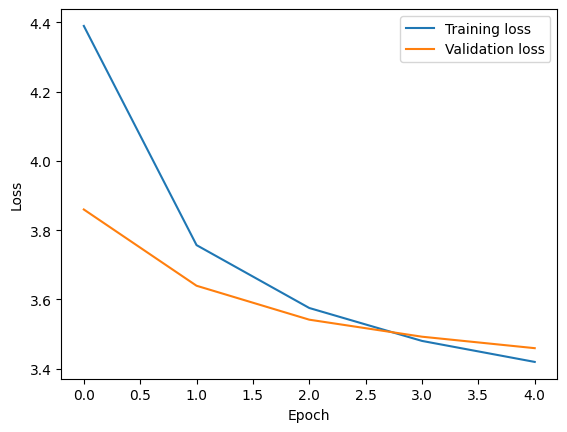

On device cpu.
On device cpu.
Training Accuracy:     0.3094
Validation Accuracy:   0.2964
On device cpu.


KeyboardInterrupt: 

In [19]:
torch.manual_seed(seed)
device = set_device()

batch_size=512
train_loader_embedding = DataLoader(data_train_embedding, batch_size=batch_size, shuffle=True)
val_loader_embedding = DataLoader(data_val_embedding, batch_size=batch_size, shuffle=True)
test_loader_embedding = DataLoader(data_test_embedding, batch_size=batch_size, shuffle=True)

embedding_model_1 = MyEmbedding1(10)
embedding_model_2 = MyEmbedding2(10)
embedding_model_3 = MyEmbedding3(10)

embedding_models = [embedding_model_1,embedding_model_2, embedding_model_3]


if os.path.isfile(PATH_GENERATED + 'best_embedding_model.pt'):
    # Load the trained models
    best_embedding_model = torch.load(PATH_GENERATED + 'best_embedding_model.pt')
    best_embedding_model.to(device)
else:
    best_embedding_model = None
    best_embedding_acc = 0 

    num_trained = 0
    for model in embedding_models:
        num_trained +=1 
        MODEL_FNAME = f'embedding_{num_trained}.pt'

        model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        loss_fn = nn.CrossEntropyLoss()                             
        n_epochs=5

        train(n_epochs, optimizer, model, loss_fn, train_loader_embedding, val_loader_embedding)

        acc_train = compute_accuracy(model, train_loader_embedding)
        acc_val = compute_accuracy(model, val_loader_embedding)

        if best_embedding_acc < acc_val: 
            best_embedding_model = model 
        
        print("Training Accuracy:     %.4f" %acc_train)
        print("Validation Accuracy:   %.4f" %acc_val)

    torch.save(best_embedding_model.to(device="cpu"), PATH_GENERATED + 'best_embedding_model.pt')

## Task 2.1.5

In [ ]:

def cos_sin(weights): 
    similarity_matrix = []
    for i in range(len(weights)):
        similarity_matrix.append(F.cosine_similarity(weights[i], weights, dim=1))
    return similarity_matrix



# Load trained embedding model and vocabulary
model_path = 'generated/model.pt'
vocab_path = "generated/vocabulary.pt"
model = torch.load(model_path)
vocab = torch.load(vocab_path)


# Compute cosine similarity matrix
weights = model.embedding.weight
similarity_matrix = cos_sin(weights)

sample_words = ['head', 'you', 'boy', 'no', 'child', 'school', 'yes', 'chair']

top_k = 10

for word in sample_words:

    if word in vocab:

        idx = vocab[word]
        sim_scores = similarity_matrix[idx]
        sim_vals, sim_indices = torch.topk(sim_scores, 10)
        #sim_indices = np.argsort(sim_scores)[:top_k]

        sim_words = [vocab.lookup_token(i) for i in sim_indices]
        print("Most similar words to '%s':" % word)
        print(sim_words)


Most similar words to 'head':
['head', 'eyes', 'lips', 'forehead', 'face', 'arms', 'hair', 'chest', 'teeth', 'arm']
Most similar words to 'you':
['you', 'ye', 'i', 'we', 'thee', 'myself', 'us', 'everybody', 'me', 'ourselves']
Most similar words to 'boy':
['boy', 'fellow', 'instinct', 'maid', 'devil', 'doctor', 'wife', 'law', 'cat', 'bishop']
Most similar words to 'no':
['no', 'any', 'become', 'according', 'sufficient', 'been', 'different', 'increased', 'existed', 'such']
Most similar words to 'child':
['child', 'lad', 'fellow', 'family', 'peasant', 'creature', 'stranger', 'society', 'woman', 'convict']
Most similar words to 'yes':
['yes', 'to-day', 'all', 'sir', 'none', 'tomorrow', 'well', 'abruptly', 'sure', 'why']
Most similar words to 'chair':
['chair', 'shield', 'tomb', 'height', 'gun', 'duty', 'youth', 'nose', 'kinds', 'hat']


## Task 2.1.6

In [ ]:
vocab_df = pd.DataFrame(vocab.lookup_tokens([i for i in range(len(vocab))]))
vocab_df.to_csv('vocab_df.tsv', sep="\t", header=False, index=False)

embedding_df = pd.DataFrame(model.embedding.weight.data.numpy())
embedding_df.to_csv('embedding_df.tsv', sep="\t", header=False, index=False)

# Task 2.2.1

In [ ]:
# ------------------------ Define targets ------------------------------
def compute_label_conjugation(w):
    """
    helper function to define MAP_TARGET
    
    - 0 = 'unknown word'
    - 1 = 'punctuation' (i.e. the '<unk>' token)
    - 2 = 'is an actual word'
    """
    if w in ['be', 'am', 'are', 'is', 'was', 'were', 'been', 'being', 'have', 'has', 'had', 'having']:
        return 0
    else:
        return 1

# true labels for this task:
MAP_TARGET = {}
i = 0
for word in ['be', 'am', 'are', 'is', 'was', 'were', 'been', 'being', 'have', 'has', 'had', 'having']: 
    MAP_TARGET[word] = i
    i += 1

# context size for this task 
CONTEXT_SIZE = 3


# ---------------- Define context / target pairs -----------------------
def create_dataset_conjugation(
    text, vocab, 
    context_size=CONTEXT_SIZE, map_target=MAP_TARGET
):
    """
    Create a pytorch dataset of context / target pairs from a text
    """
    
    n_text = len(text)
    n_vocab = len(vocab)
    
    # Change labels if only a few target are kept, otherwise, each word is
    # associated with its index in the vocabulary
    if map_target is None:
        map_target = {i:i for i in range(n_vocab)}
    
    # Transform the text as a list of integers.
    txt = [vocab[w] for w in text]

    # Start constructing the context / target pairs...
    contexts = []
    targets = []
    for i in range(n_text - 2*context_size):
        
        # Word used to define target
        t = txt[i + context_size]
        
        # Context before the target and after the target. 
        c = txt[i: i+context_size]
        c += txt[i+context_size+1 : i + (2*context_size)+1]
        
        if compute_label_conjugation(vocab.lookup_token(t)) == 0:
            targets.append(map_target[vocab.lookup_token(t)])
            contexts.append(torch.tensor(c))
            
    # contexts of shape (N_dataset, context_size)
    # targets of shape  (N_dataset)
    contexts = torch.stack(contexts)
    targets = torch.tensor(targets)
    # Create a pytorch dataset out of these context / target pairs

    print(len(contexts), len(targets))
    return TensorDataset(contexts, targets)

def load_dataset_conjugation(words, vocab, fname):
    """
    Load dataset if already generated, otherwise, create it and save it
    """
    # If already generated
    if os.path.isfile(PATH_GENERATED + fname):
        dataset = torch.load(PATH_GENERATED + fname)
    else:
        # Create context / target dataset based on the list of strings
        dataset = create_dataset_conjugation(words, vocab)
        torch.save(dataset, PATH_GENERATED + fname)
    return dataset

data_train_conjugation = load_dataset_conjugation(words_train, vocab, "data_train_conjugation.pt")
data_val_conjugation = load_dataset_conjugation(words_val, vocab, "data_val_conjugation.pt")
data_test_conjugation = load_dataset_conjugation(words_test, vocab, "data_test_conjugation.pt")

In [ ]:
class MLP(nn.Module):
    def __init__(self, embedding_matrix, max_len):
        super(MLP, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix)
        self.fc1 = nn.Linear(max_len * embedding_matrix.shape[1], 256)                                       
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 12)

    def forward(self, input_ids):
        embeddings = self.embedding(input_ids)
        x = embeddings.view(embeddings.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
    
import math

class MLPWithAttention(nn.Module):
    def __init__(self, embedding_matrix, emb_dim, max_len, num_classes=12):
        super(MLPWithAttention, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix)
        self.fc1 = nn.Linear(emb_dim * max_len, 64)
        self.fc2 = nn.Linear(64, num_classes)
        self.positional_encoding = self.positional_encoding(max_len, emb_dim)

    def forward(self, x):
        embedded = self.embedding(x).view(x.shape[0], -1)
        if self.positional_encoding is not None:
            embedded = embedded + self.positional_encoding
        x = self.fc1(embedded)
        x = F.relu(x)
        x = self.fc2(x)
        return x
    
    def positional_encoding(self, max_len, emb_dim):
        pe = torch.zeros(max_len, emb_dim)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        pe = pe.to(device)
        for i in range(max_len):
            for j in range(0, emb_dim, 2):
                k = j // 2
                pe[i, j] = math.sin(i / (10000 ** (k / emb_dim)))
                pe[i, j + 1] = math.cos(i / (10000 ** (k / emb_dim)))
        return pe.flatten()
    
class RNN_conjugation(nn.Module):
    def __init__(self, embedding_matrix, hidden_size, num_classes=11):
        super(RNN_conjugation, self).__init__()

        self.embedding = nn.Embedding.from_pretrained(embedding_matrix)
        self.rnn = nn.LSTM(embedding_matrix.shape[1], hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 12)

    def forward(self, x):
        x = self.embedding(x)
        _, (h_n, c_n) = self.rnn(x)
        out = self.fc(h_n[-1])
        return out

In [ ]:

torch.manual_seed(seed)
device = set_device()


MODEL_FNAME = "model_conjugation.pt"

batch_size=512
train_loader_conjugation = DataLoader(data_train_conjugation, batch_size=batch_size, shuffle=True)
val_loader_conjugation = DataLoader(data_val_conjugation, batch_size=batch_size, shuffle=True)
test_loader_conjugation = DataLoader(data_test_conjugation, batch_size=batch_size, shuffle=True)

mlp_model = MLP(model.embedding.weight.data, 2*CONTEXT_SIZE) #2*contex_size fordi det er 3 ord på hver side. 

if os.path.isfile(PATH_GENERATED + MODEL_FNAME):
    # Load the trained model
    mlp_model = torch.load(PATH_GENERATED + MODEL_FNAME)
    mlp_model.to(device)
else:
    # Or train the model...
    mlp_model.to(device)
    optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()                             #Add weights
    n_epochs=5

    train(n_epochs, optimizer, mlp_model, loss_fn, train_loader_conjugation)
    # ... and save it
    torch.save(mlp_model.to(device="cpu"), PATH_GENERATED + MODEL_FNAME)

acc_train = compute_accuracy(mlp_model, train_loader_conjugation)
acc_val = compute_accuracy(mlp_model, val_loader_conjugation)
print("Training Accuracy:     %.4f" %acc_train)
print("Validation Accuracy:   %.4f" %acc_val)

On device cpu.
On device cpu.
13:39:24.513248  |  Epoch 1  |  Training loss 1.47381
13:39:25.916884  |  Epoch 2  |  Training loss 1.22579
13:39:27.355995  |  Epoch 3  |  Training loss 1.15505
13:39:28.641181  |  Epoch 4  |  Training loss 1.11241
13:39:30.167310  |  Epoch 5  |  Training loss 1.08258
On device cpu.
On device cpu.
Training Accuracy:     0.6022
Validation Accuracy:   0.5923


In [ ]:
torch.manual_seed(seed)
device = set_device()


MODEL_FNAME = "model_conjugation_with_attention.pt"

batch_size=512
train_loader_conjugation = DataLoader(data_train_conjugation, batch_size=batch_size, shuffle=True)
val_loader_conjugation = DataLoader(data_val_conjugation, batch_size=batch_size, shuffle=True)
test_loader_conjugation = DataLoader(data_test_conjugation, batch_size=batch_size, shuffle=True)


mlp_with_attention_model = MLPWithAttention(embedding_matrix=model.embedding.weight.data, emb_dim=10, max_len=CONTEXT_SIZE*2)

if os.path.isfile(PATH_GENERATED + MODEL_FNAME):
    # Load the trained models
    mlp_with_attention_model = torch.load(PATH_GENERATED + MODEL_FNAME)
    mlp_with_attention_model.to(device)
else:
    # Or train the model...
    mlp_with_attention_model.to(device)
    optimizer = optim.Adam(mlp_with_attention_model.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()                             #Add weights
    n_epochs=10

    train(n_epochs, optimizer, mlp_with_attention_model, loss_fn, train_loader_conjugation)
    # ... and save it
    torch.save(mlp_with_attention_model.to(device="cpu"), PATH_GENERATED + MODEL_FNAME)

acc_train = compute_accuracy(mlp_with_attention_model, train_loader_conjugation)
acc_val = compute_accuracy(mlp_with_attention_model, val_loader_conjugation)
print("Training Accuracy:     %.4f" %acc_train)
print("Validation Accuracy:   %.4f" %acc_val)


On device cpu.
On device cpu.
13:40:05.451126  |  Epoch 1  |  Training loss 1.66255
13:40:06.509422  |  Epoch 2  |  Training loss 1.34991
13:40:07.575759  |  Epoch 3  |  Training loss 1.27999
13:40:08.660360  |  Epoch 4  |  Training loss 1.23433
13:40:09.931982  |  Epoch 5  |  Training loss 1.20363
On device cpu.
On device cpu.
Training Accuracy:     0.5575
Validation Accuracy:   0.5722


In [ ]:
torch.manual_seed(seed)
device = set_device()


MODEL_FNAME = "model_conjugation_RNN.pt"

batch_size=256
train_loader_conjugation = DataLoader(data_train_conjugation, batch_size=batch_size, shuffle=True)
val_loader_conjugation = DataLoader(data_val_conjugation, batch_size=batch_size, shuffle=True)
test_loader_conjugation = DataLoader(data_test_conjugation, batch_size=batch_size, shuffle=True)


rnn_conjugation = RNN_conjugation(model.embedding.weight.data, 10, 4)

if os.path.isfile(PATH_GENERATED + MODEL_FNAME):
    # Load the trained models
    rnn_conjugation = torch.load(PATH_GENERATED + MODEL_FNAME)
    rnn_conjugation.to(device)
else:
    # Or train the model...
    rnn_conjugation.to(device)
    optimizer = optim.Adam(rnn_conjugation.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()                             #Add weights
    n_epochs=10

    train(n_epochs, optimizer, rnn_conjugation, loss_fn, train_loader_conjugation)
    # ... and save it
    torch.save(rnn_conjugation.to(device="cpu"), PATH_GENERATED + MODEL_FNAME)

acc_train = compute_accuracy(rnn_conjugation, train_loader_conjugation)
acc_val = compute_accuracy(rnn_conjugation, val_loader_conjugation)
print("Training Accuracy:     %.4f" %acc_train)
print("Validation Accuracy:   %.4f" %acc_val)

On device cpu.
On device cpu.
13:40:18.257339  |  Epoch 1  |  Training loss 2.12639
13:40:19.834686  |  Epoch 2  |  Training loss 1.66584
13:40:21.562306  |  Epoch 3  |  Training loss 1.49987
13:40:23.131431  |  Epoch 4  |  Training loss 1.43099
13:40:24.698232  |  Epoch 5  |  Training loss 1.38875
13:40:26.275827  |  Epoch 6  |  Training loss 1.35797
13:40:28.054537  |  Epoch 7  |  Training loss 1.33337
13:40:29.881021  |  Epoch 8  |  Training loss 1.31236
13:40:32.031675  |  Epoch 9  |  Training loss 1.29736
13:40:33.862995  |  Epoch 10  |  Training loss 1.28453
On device cpu.
On device cpu.
Training Accuracy:     0.5296
Validation Accuracy:   0.5266


# Task 2.3

In [ ]:

# true labels for this task:
MAP_TARGET = {
    vocab[w]:compute_label(w) for w in vocab.lookup_tokens(range(VOCAB_SIZE))
}

# context size for this task 
CONTEXT_SIZE = 3


# ---------------- Define context / target pairs -----------------------
def create_dataset_generation(
    text, vocab, 
    context_size=CONTEXT_SIZE, map_target=None
):
    """
    Create a pytorch dataset of context / target pairs from a text
    """
    
    n_text = len(text)
    n_vocab = len(vocab)
    
    # Change labels if only a few target are kept, otherwise, each word is
    # associated with its index in the vocabulary
    if map_target is None:
        map_target = {i:i for i in range(n_vocab)}
    
    # Transform the text as a list of integers.
    txt = [vocab[w] for w in text]

    # Start constructing the context / target pairs...
    contexts = []
    targets = []
    for i in range(n_text - context_size):
        
        # Word used to define target
        t = txt[i + context_size]
        
        # Context before the target. 
        c = txt[i: i+context_size]
        
        if compute_label(vocab.lookup_token(t)) == 2:
            targets.append(map_target[t])
            contexts.append(torch.tensor(c))
            
    # contexts of shape (N_dataset, context_size)
    # targets of shape  (N_dataset)
    contexts = torch.stack(contexts)
    targets = torch.tensor(targets)
    # Create a pytorch dataset out of these context / target pairs
    return TensorDataset(contexts, targets)

def load_dataset(words, vocab, fname):
    """
    Load dataset if already generated, otherwise, create it and save it
    """
    # If already generated
    if os.path.isfile(PATH_GENERATED + fname):
        dataset = torch.load(PATH_GENERATED + fname)
    else:
        # Create context / target dataset based on the list of strings
        dataset = create_dataset(words, vocab)
        torch.save(dataset, PATH_GENERATED + fname)
    return dataset

data_train_generation = load_dataset(words_train, vocab, "data_train_generation.pt")
data_val_generation  = load_dataset(words_val, vocab, "data_val_generation.pt")
data_test_generation  = load_dataset(words_test, vocab, "data_tes_generationt.pt")

In [ ]:
class RNN_generation(nn.Module):
    def __init__(self, embedding_matrix, hidden_size):
        super(RNN_generation, self).__init__()

        self.embedding = nn.Embedding.from_pretrained(embedding_matrix)
        self.rnn = nn.LSTM(embedding_matrix.shape[1], hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, VOCAB_SIZE)

    def forward(self, x):
        x = self.embedding(x)
        _, (h_n, c_n) = self.rnn(x)
        out = self.fc(h_n[-1])
        return out

In [ ]:
torch.manual_seed(seed)
device = set_device()


MODEL_FNAME = "model_generation_RNN.pt"

batch_size=256
train_loader_generation = DataLoader(data_train_generation, batch_size=batch_size, shuffle=True)
val_loader_generation = DataLoader(data_val_generation, batch_size=batch_size, shuffle=True)
test_loader_generation = DataLoader(data_test_generation, batch_size=batch_size, shuffle=True)


rnn_generation = RNN_generation(model.embedding.weight.data, 4)

if os.path.isfile(PATH_GENERATED + MODEL_FNAME):
    # Load the trained models
    rnn_generation = torch.load(PATH_GENERATED + MODEL_FNAME)
    rnn_generation.to(device)
else:
    # Or train the model...
    rnn_generation.to(device)
    optimizer = optim.Adam(rnn_generation.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()                             #Add weights
    n_epochs=10

    train(n_epochs, optimizer, rnn_generation, loss_fn, train_loader_generation)
    # ... and save it
    torch.save(rnn_generation.to(device="cpu"), PATH_GENERATED + MODEL_FNAME)

acc_train = compute_accuracy(rnn_generation, train_loader_generation)
acc_val = compute_accuracy(rnn_generation, val_loader_generation)
print("Training Accuracy:     %.4f" %acc_train)
print("Validation Accuracy:   %.4f" %acc_val)

On device cpu.
On device cpu.
13:07:08.990229  |  Epoch 1  |  Training loss 5.73254
13:07:53.338535  |  Epoch 2  |  Training loss 5.25246
13:08:37.253279  |  Epoch 3  |  Training loss 5.06019
13:09:24.087912  |  Epoch 4  |  Training loss 5.00705
13:16:27.723742  |  Epoch 5  |  Training loss 4.98174
13:17:16.579717  |  Epoch 6  |  Training loss 4.96604
13:18:02.922742  |  Epoch 7  |  Training loss 4.95492
13:18:48.408042  |  Epoch 8  |  Training loss 4.94582
13:20:04.048463  |  Epoch 9  |  Training loss 4.93814
13:20:55.519463  |  Epoch 10  |  Training loss 4.93107
On device cpu.
On device cpu.
Training Accuracy:     0.1359
Validation Accuracy:   0.1316
